# Copulas and Random Numbers

> <big>📝</big> <sub> Citations are denoted by superscript citation <sup>[ID]</sup> keys and provided in full at the end of the notebook, they have not been hyperlinked</sub>. Where not otherwise specified definitions are taken from <sup>[NEL]</sup>

## Initial Setup

### Install Dependencies
The following loop should install and load the packages used in this notebook <sup>[Dis.JL-416]</sup>

Due to the JIT it can take 10-20 seconds to load the libraries.

In [1]:
using Pkg
package_dependencies = [
    :IJulia,
    :Distributions,
    :GR,
    :Plots,
    :PlotlyJS,
    :PyPlot,
    :SymPy];
@time for p in package_dependencies
    try
        @eval using $p
    catch
        try
            Pkg.add(p)
        catch
            print("Unable to install $p \n")
            continue
        end
    end
end
print("Finished Loading Dependencies")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-412307266526820844\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1690702174232734071\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-412307266526820844\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

 10.828443 seconds (20.46 M allocations: 1.292 GiB, 4.75% gc time)
Finished Loading Dependencies

### Set up Jupyter

After installing *IJulia* make sure to restart *Jupyter*, if there are still issues try running the following from a *Julia* interpreter:
        
```julia
# Install ipympl with pip (see also [aur-ipympl]
; pip install ipympl
# start a notebook
using IJulia
notebook()
```

Solve some ODE's

### Set up PlotlyJS inside Jupyter
> Refer to:
>  * [IJulia Docs](https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/#IJulia)
>  * [WebIO Docs](https://juliagizmos.github.io/WebIO.jl/latest/troubleshooting/not-detected/)

<!---
At the time of writing [PlotlyJS.jl] is incompatible with JupyterLab <a href="#WIO442"><sup>[WIO442]</sup></a> and hence won't be used in this notebook.

Edit: Nevermind, it started working and the `anim()` in GR broke so we'll run with PlotlyJS
--->

```julia
using WebIO
# Notebook
WebIO.install_jupyter_nbextension()
# Jupyter lab
WebIO.install_jupyter_labextension()
```


[PlotlyJS.jl]: https://github.com/JuliaPlots/PlotlyJS.jl

## Introduction to Copulas

Copulas are a type of multi-variable function with a domain on $\left[0,1\right]^n$, these functions are of interest because they are the types of functions that can be used to describe the interaction of marginal probabilities in a joint probability distribution.

For the sake of introducing copulas, there is no need to consider statistical distributions, merely the properties of this type of a function.

In 2-variables a sub-Copula $C$ is defined as a function that is:

1.  defined on domain $\left[0,1\right]^n$

    1. If the domain is is given by $S_{1}\times S_{2}$where
    $S_{1},S_{2}\in\left\{ 0,x,1\mid x\subset\left[0,1\right]\right\}$ but all other conditions are satisfied, the function is said to be a sub-copula ($C^\star$)

    1. In essence the domain is atleast a subset of the unit square that contains the
        perimiter

2.  The function is grounded </br>$\left(x=0\right)\lor\left(y=0\right)\implies C'\left(x,y\right)=0$</br>

    

3.  For every square in the domain
    $\left(x_{1}\leq x_{2}\land y_{1}\leq y_{2}\right)\in\left(S_{1}\times S_{2}\right)$
    the *H-Volume* is positive, i.e. </br> $C'\left(x_{1},y_{1}\right)+C'\left(x_{2},y_{2}\right)+C'\left(x_{1},y_{2}\right)+C'\left(x_{2},y_{1}\right)\geq0$
    
    - This is also known as being quasi-monotone or 2-increasing

4.  There exist Marginal Functions

    1.  $C'\left(x,1\right)=x,\forall x\in S_{1}$

    2.  $C'\left(1,y\right)=y,\forall y\in S_{2}$




So for example, consider functions:

$$\begin{aligned}
F(x) &= x \\
G(y) &= y
\end{aligned}$$

These could be comined in a variety of ways, consider however:

$$\begin{matrix}
H_1(x, y) = x\times y &\,& H_2(x,y) = x+y
\end{matrix}$$

This can be plotted like so:

In [2]:
# Load the packages
using PlotlyJS, DataFrames, RDatasets, Colors, Distributions, LinearAlgebra

# A function to produce a plot
function plotly_distribution(func; copula = true, resolution = 100)
    n = resolution

    if copula
      # Domain Square
      vals = [i/n for i in 0:n]
    else
      vals = range(-n, n, length = 20*n)
    end

    # Heights matrix over square
    zM = [func(x,y) for x in vals, y in vals]
    
    # Make the Surface plot
    traceM = PlotlyJS.surface(z=zM, x = vals, y = vals, showscale=false, opacity=0.9, colorscale="Viridis")

    # Adjust the rotation
    
    
    # Actually plot them
    p = PlotlyJS.plot([traceM])
    
    return(p)

#    PlotlyJS.savefig(p, "/tmp/file.html")
end


plotly_distribution (generic function with 1 method)

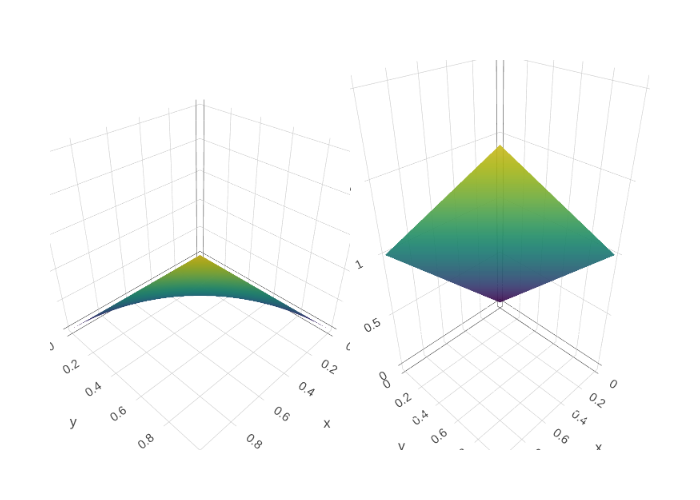

In [3]:
# Use pure functions to make plots
pl = plotly_distribution((x,y) -> x*y); # supress output
pr = plotly_distribution((x,y) -> x+y);

# Make the plots as subplots
# http://juliaplots.org/PlotlyJS.jl/stable/manipulating_plots/#Subplots
[pl pr]



Observe that the left function is grounded (stuck to the floor along the axis) and that surrounding every point the $H$-volume is positive (i.e. the height of the diagonal corners is larger than the height of the offset corners).

The function depicted on the right does satisfy the quasi-monotone property but it is not grounded and hence not a copula.

### Marginal Functions

If a function $H$ is defined on the domain
$S_{1}\times S_{2}\in\mathbb{R}^{2}$such that:

-   $\sup\left(S_{1}\right)=b_1$

-   $\sup\left(S_{2}\right)=b_{2}$

Then the margins are said to be functions:

-   $F\left(x\right)=H\left(x,b_{2}\right)$

-   $G\left(y\right)=H\left(b_{1},y\right)$

In the case of a copula, the maximum value on either axis in the domain
is 1 and hence the margins of a copula are:

-   $F\left(x\right)=H\left(x,1\right)$

-   $G\left(y\right)=H\left(1,y\right)$

The definition of a copula requires the existence of these marginal
functions and so any sub-copula must be well defined along the edges of the domain.


### Range of a Copula

Given the properties of a copula, it can be shown as a *consequence* (rather than a requirement) that the range must be on $\left[0,1\right]$.

This can be shown by observing that the upper bound of any supcopula $C^\star(x,y)$ is given by:

$$\begin{aligned}
\mathrm{Vol}_{C^{\star}}\left(\left[u,1\right]\times\left[v,1\right]\right)&\geq0\\C^{\star}\left(u,v\right)+C^{\star}\left(1,1\right)-C^{\star}\left(u,1\right)-C^{\star}\left(1,v\right)&\geq0\\C^{\star}\left(u,v\right)&\geq u+v-1\\C^{\star}\left(u,v\right)&\leq1-u-v\\C^{\star}\left(u,v\right)&\leq1-0-0\\C^{\star}\left(u,v\right)&\leq1
\end{aligned}$$

and that the lower bound is given by:

$$\begin{aligned}
    \mathrm{Vol}_{C^{\star}}\left(\left[0,u\right]\times\left[0,v\right]\right)	\geq0 \\
C^{\star}\left(0,0\right)+C^{\star}\left(0,v\right)+C^{\star}\left(u,0\right)+C^{\star}\left(u,v\right)	\geq0 \\
C^{\star}\left(u,v\right)	\geq0
    \end{aligned}$$

### Bounds of a Copula (Frechet-Hoeffding Bounds)

Because a sub-copula is *quasi-monotone*, it has a positive volume for
all rectangles in the domain, this means that for any given point
$\left(u,v\right)\in\left[0,1\right]^{2}$ and by the definition of a
copula, marginal functions exist along the maximum domain values, hence:

$$\begin{aligned}
C'\left(u,v\right) & \leq C'\left(u,1\right)=u\land C'\left(u,v\right)\leq C'\left(1,v\right)=1\end{aligned}$$

and combining these provides:

$$C'\left(u,v\right)\leq\mathrm{\min\left(u,v\right)}$$

Note also that the volume of a copula:

$$\begin{aligned}
\mathrm{Vol}_{C'}\left(\left[0,u\right]\times\left[0,v\right]\right) & =C'\left(0,0\right)+C'\left(u,v\right)-C'\left(u,0\right)-C'\left(0,v\right)\\
 & =C'\left(u,v\right)\end{aligned}$$

By the definition of volume:

$$\begin{aligned}
\mathrm{vol_{C'}}\left(\left[0,u\right]\times\left[0,v\right]\right) & \leq\mathrm{vol_{C'}}\left(\left[u,1\right]\times\left[v,1\right]\right)\\
C'\left(u,v\right) & \leq\mathrm{vol_{C'}}\left(\left[u,1\right]\times\left[v,1\right]\right)\\
 & \leq C'\left(0,0\right)+C'\left(1,1\right)+C'\left(u,1\right)+C'\left(v,1\right)\\
 & \leq0+1-u-v\\
 & \geq u+v-1\end{aligned}$$

A copula has a range of $\left[0,1\right]$ and hence the copula will
have a lower bound:

$$C'\left(u,v\right)\geq\max\left(u+v-1,0\right)$$

And the bounds of the copula are hence:

$$\max\left(u+v-1,0\right)\leq C'\left(u,v\right)\leq\min\left(u,v\right)$$


### Continuity of a Copula

The *Lipshcitz Condition* <sup>[EoMLIP]</sup> provides a sufficient condition to show that a
function is uniformly continuous on $\left[a,b\right]$, namely if: <sup>[NEL]</sup>

$$\left|f\left(x\right)-f\left(x'\right)\right|\leq M\left|x-x'\right|\quad\forall x,x'\in\left[a,b\right]$$
By the triangle inequality it can be shown that:

$$\left|C'\left(u_{2},v_{2}\right)-C'\left(u_{1},v_{1}\right)\right|\leq\left|u_{2}-u_{1}\right|+\left|v_{2}-v_{1}\right|$$

and so a copula is uniformly continuous on $\left[0,1\right]$.

Note however that there is no requirement that a copula be a bijection (one-to-one function with a saturated range), a copula is not necessarily invertible.

<!---
A copula can be thought of like a map from $\left[0,1\right]$to some rectangle
$\left[0,u\right]\times\left[0,v\right]$ because
$\mathrm{vol_{C'}\left(\left[0,u\right]\times\left[0,v\right]\right)=C'\left(u,v\right)}.$
--->

### Distribution Functions

#### Distribution Functions

A distribution function $F:\mathbb{R}\rightarrow\left[0,1\right]$ is
such that:

-   $F$ is non-decreasing

-   $F\left(-\infty\right)=0$

-   $F\left(\infty\right)=1$




##### Example

Imagine filling up a bucket from a tap, if the the time was represented along the $x$-axis and
the proportion filled on the $y$-axis, this could be denoted by a distribution
function.

#### Unit Step Function

The unit step function is another example of a distribution function, this is illustrated below: [^832]
    
    
[^832]: Produced with *[Inkscape]* <sup>[INK]</sup>
    
[Inkscape]: https://inkscape.org/
    

<img src="./media/unit-step.svg" alt="Unit Step Function" style="width: 200px;"/>

<!---
![](./media/unit-step.svg)
--->

##### Uniform Distribution

The uniform distribution is another example of a distribution function, this is visualised below by a cumulative distribution function (CDF) and probability distribution function (PDF).

<img src="./media/uniform-distribution.svg" alt="Uniform Distribution Function" style="width: 200px;"/>

<!---
![](./media/uniform-distribution.svg)
--->

#### Joint Distributions

A joint distribution function is some function $H$ with a domain on
$\mathbb{R}^{2}$ that satisfies these 3 properties:

1.  Quasi-Monotone

2.  Grounded </br> $H\left(x,-\infty\right)=H\left(y,-\infty\right)=0$

3.  $H\left(\infty,\infty\right)$=1

These properties implies the existence of marginals, because the function
is 2-increasing and grounded with the domain $\mathbb{R}^{2}$, so it
follows that $\exists F,G$:

-   $F\left(x\right)=H\left(x,\infty\right)$

-   $G\left(y\right)=H\left(\infty,y\right)$

These marginals also satisfiy the definition of distribution functions.



#### Continuity

Due to the existence of marginals, the triangle inequality can be used
to give:

$$\left|H\left(u_{2},v_{2}\right)-H\left(u_{1},v_{1}\right)\right|\leq\left|F\left(u_{2},v_{2}\right)-F\left(u_{1},v_{1}\right)\right|+\left|G\left(u_{2},v_{2}\right)-G\left(u_{1},v_{1}\right)\right|$$

which satisfies the *Lipshcitz Condition* and hence a joint distribution
function is uniformly continuous.



### Invertibility of a Copula

When talking about the inverse of a copula or distribution function, it is useful allow the substitution of a quasi-inverse function.

If $F$ is a distribution function, the quasi-inverse of $F$ is given by $F^{(-1)}$:

$$
F\left(F^{-1}\left(t\right)\right) = t
$$

If however $t$ is not in the range of $F$ then the quasi-inverse is given by taking the nearest value:

$$\begin{aligned}
F^{\left(-1\right)}\left(t\right)	=\inf\left\{ x\mid F\left(x\right)\geq t\right\}  \\
	=\sup\left\{ x\mid F\left(x\right)\leq t\right\} 
\end{aligned}$$

This is visualised in the below diagram:

<img src="./media/quasi-inverse.svg" alt="Diagram of Quasi Inverse" style="width: 200px;"/>



### Sklars Theorem

Sklar's Theorem is in essence the reason copulas are of any interest (as opposed to merely being a subset of various types of different real functions), the theorem provides thatf $H$ is a joint distribution function with margins $F$ and $G$, then
there exists a copula $C$ such that:

$$H\left(x,y\right)=C\left(F\left(x\right), G\left(y\right)\right)$$

This copula can be solved by reversing the relationship and using quasi-inverse functions:

$$C\left(u,v\right)=H\left(F^{-1}\left(x\right),G^{-1}\left(y\right)\right)$$

#### Bringing Probability into it

If $H$ is a joint-probability distribution, then the benefit of this can be more clearly seen. The copula function will describe the joint probability distribution function
$H\left(x,y\right)$ by a new function
$C:\mathbb{R}^{2}\rightarrow\mathbb{R}$ that takes inputs as probabilities to give an overall probability. This means the copula function describes only the interrelation between the two variables, everything else has been boiled away to only show the inter-dependence between the variables.






#### Random Variables

If we let the following definitions hold:

$$\begin{aligned}
F\left(x\right) & =P\left[X\leq x\right]\\
G\left(y\right) & =P\left[Y\leq y\right]\end{aligned}$$

Where:

-   $X,Y$ are random variables

-   $x,y$ are values

We can restate Sklar's Theorem:

If $X$ and $Y$ are random variables with distribution functions $F$ and
$G$, and a joint distribution function $H$, then there willl be a copula
$C$:

$$\begin{aligned}
H\left(x,y\right) & =C\left(F\left(x\right),G\left(y\right)\right)\end{aligned}$$

This copula function will give take in probabilities and give out
probabilities


## Generating Random Samples

In this component of the notebook, attention shifts to using copulas as a tool to generate random numbers from a given distribution. It's taken as a given that we can generate uniformly distributed values in $\left[ 0,1 \right]$ <sup>(see generally <img src="./media/wikipedias_w.svg" alt="Unit Step Function" style="width: 20px;"/>[Random Number Generation]</sup>) and our interest is to generate random samples from arbitrary distributions (thes could be of use in, e.g., Monte Carlo simulations).







[Random Number Generation]: https://en.wikipedia.org/wiki/Random_number_generation


### Univariate Distributions

#### Choosing a Distribution

In order to generate random values from a given distribution, it is necessary to know the inverse-CDF of that distribution, for this reason one must decide on one to use.

loosely speaking (!!), if we assume that:

  1. $\frac{\mathrm{d}y}{\mathrm{d}x} \propto y$
  2. $\frac{\mathrm{d}y}{\mathrm{d}x} \propto (x-\mu), \quad \exists \mu \in \mathbb{R}$

it can be shown that:

$$
\frac{\mathrm{d}y}{\mathrm{d}x} \propto y\times (x-\mu) \implies y=\frac{1}{\sigma \sqrt{2 \pi}} \exp \left(\frac{-(x-\mu)^{2}}{2 \sigma^{2}}\right)
$$


This function, the Gaussian Distribution, does not however have an elementary integral, rather a power series must be implemented and all together it's a nuisance to deal with so with a slight modification a simpler but superficially similar function can used:


  1. $\frac{\mathrm{d}y}{\mathrm{d}x} \propto y$
  2. $\frac{\mathrm{d}y}{\mathrm{d}x} \propto (1-y), \quad \exists \mu \in \mathbb{R}$

$$
\frac{\mathrm{d}y}{\mathrm{d}x} \propto y (1-y) \implies y = \frac{1}{1+e^{-x}}
$$

<!---

[^8923]: As an aside, the natural emergence of variance in this context is a really easy way to justify the use of $\sigma^2$ is used as opposed to `mean(abs(x-\mu))`

--->

This assertion can be verified by using the [SymPy.jl](https://github.com/JuliaPy/SymPy.jl) package:

In [4]:
# Import the Package
using SymPy

# Create the Functions
f, g = symbols("f g", cls=sympy.Function)
# Create the Constants
k, M, μ = symbols("k, M μ", cls = sympy.Symbol)
# Make the variables
@vars x

# State the Equation
diffeq = Eq(f(x).diff(x),1*f(x)*(1-f(x)))
# diffeq        

# Solve the ODE
dsolve(diffeq, f(x))
    
# State the Equation
diffeq = Eq(f(x).diff(x),1*f(x)*(-x)) 
# diffeq        

# Solve the ODE
dsolve(diffeq, f(x))


             2 
           -x  
           ────
            2  
f(x) = C₁⋅ℯ    

In [5]:
# State the Equation
diffeq = Eq(f(x).diff(x),1*f(x)*(x-μ))
# diffeq        

# Solve the ODE
dsolve(diffeq, f(x))

             ⎛x    ⎞
           x⋅⎜─ - μ⎟
             ⎝2    ⎠
f(x) = C₁⋅ℯ         

#### Plot the Distribution

The distributions can be compared like so:

In [6]:

function gauss(x; μ=0, σ=1)
    return 1/(σ * sqrt(2*π)) * exp(-0.5 * ((x-μ)/σ)^2)
end

function sigmoid(x; σ=1)
    return 1/(1+exp(-x*σ))
end

function sigmoid_d(x)
    return (exp(-x))/(1+exp(-x))^2
end

function inv_sig(x)
    return log(x/(1-x))
end
    

inv_sig (generic function with 1 method)

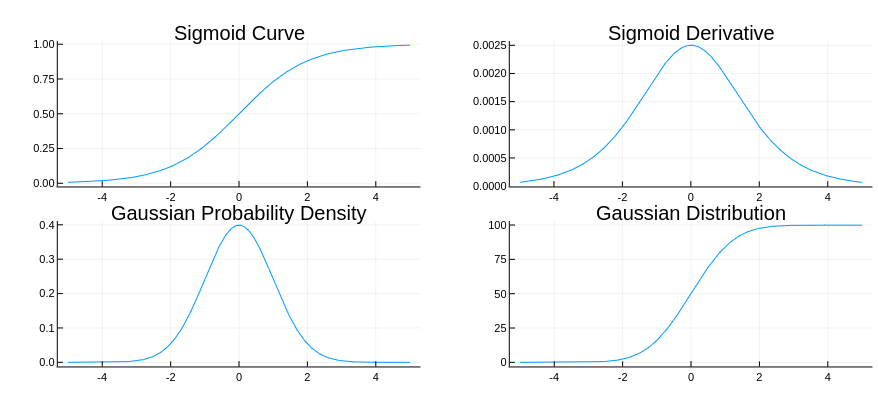

In [7]:
using Plots; plotlyjs()

# Plot the Sigmoid Curve ...................................
xv = [range(-5, stop=5, length=1000)...]
yv = [sigmoid(x) for x in xv]
ydv = diff(yv)

# Plot the Sigmoid
p1 = Plots.plot(xv,yv, legend = false, title = "Sigmoid Curve")

# Plot the derivative
deleteat!(xv, 1)
p2 = Plots.plot(xv,ydv, legend = false, title = "Sigmoid Derivative")


# Plot the Gaussian Curve ..................................

xv = [range(-5, stop=5, length=1000)...]
yv = [gauss(x) for x in xv]
yiv = cumsum(yv)

# Plot the Gaussian PDF
p3 = Plots.plot(xv,yv, legend = false, title = "Gaussian Probability Density")

# Plot the Integral
# deleteat!(xv, 1)
p4 = Plots.plot(xv,yiv, legend = false, title = "Gaussian Distribution")


# Perform the plotting
Plots.plot(p1,p2, p3, p4, layout = (2,2))



This verifies that the integral of the logistic function is superficially similar to the gaussian function.

#### Generate Random Values

Although the logistic function is typically used as a model for population growth <sup>[MATHMOD, Ch. 11]</sup> or as an activation function with neural networks <sup>[PICTON, § 3.3]</sup> and logistic regression <sup>[ISL, § 4.3]</sup>, it is also used as a distribution with copulas as a marginal distribution in Hyrdrology <sup>[LuH2O, § 9.2.3.1]</sup>, so generating random values from this type of a univariate distribution is not merely for the sake of simplification, it does have applications.



See also:
* <img src="./media/wikipedias_w.svg" alt="Unit Step Function" style="width: 20px;"/>[Logistic Function]</sup>
* <img src="./media/wikipedias_w.svg" alt="Unit Step Function" style="width: 20px;"/>[Logistic Distribution]
</sup>
* <img src="./media/wikipedias_w.svg" alt="Unit Step Function" style="width: 20px;"/>[Normal Distribution]</sup>
* [🝆 Distributions.jl; Logistic Distribution](https://juliastats.org/Distributions.jl/v0.14/univariate.html)
* [***R***-stats::rlogis](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Logistic.html)

[Logistic Function]: https://en.wikipedia.org/wiki/Logistic_function#In_ecology:_modeling_population_growth
[Logistic Distribution]: https://en.wikipedia.org/wiki/Logistic_distribution
[Normal Distribution]: https://en.wikipedia.org/wiki/Normal_distribution

in order to generate random values, the inverse function used and given  uniform input values $\left[0,1\right]$:

$$
F\left(x\right)=\frac{1}{1+e^{-x}}\implies F^{-1}\left(x\right)=\ln\left(\frac{x}{1-x}\right)
$$

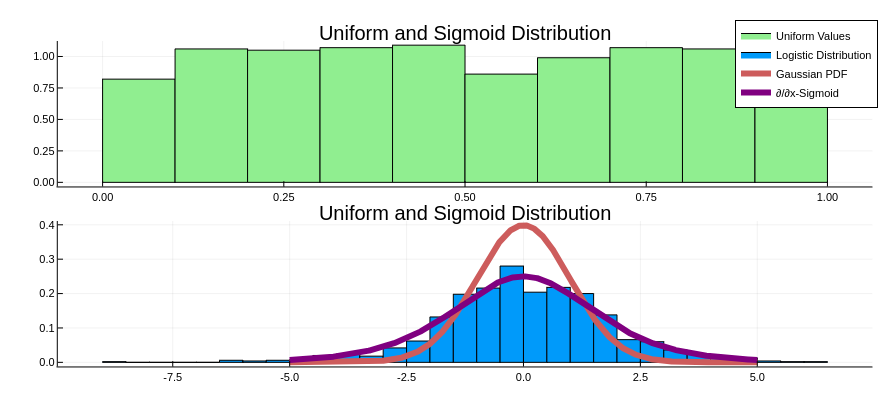

In [8]:
using Distributions

# Use the plotlyjs backend
plotlyjs()

unif_vals = rand(Uniform(0,1), Int(1E3))
sig_vals = [inv_sig(x) for x in unif_vals]

# Uniform Plot
p1 = Plots.histogram(unif_vals, title = "Uniform Values", legend = false, normalize = true,
label = "Uniform Values", color = "light green");
p2 = Plots.histogram(sig_vals, title = "Sigmoid Distribution", legend = false, normalize = true,
label = "Logistic Distribution");

    # Plot a bell curve
    xv = [range(-5, stop=5, length=1000)...]
    yv = [gauss(x) for x in xv]
    yv_d = [exp(-x)/(1+exp(-x))^2 for x in xv]
    Plots.plot!(xv,yv, lw = 6, color = "indianred", label = "Gaussian PDF")
    
    # Plot a sigmoid
    yv = [sigmoid_d(x) for x in xv]
    Plots.plot!(xv,yv, lw = 6, color = "purple", label = "∂/∂x-Sigmoid ")


Plots.plot(p1, p2, layout = (2,1), title = "Uniform and Sigmoid Distribution", normalize = true, legend = true)


##### Justifying the process

Intuitively each probabilistic quantile would be equally as likely when sampling from a random distribution, however a more rigorous intuitive understanding of this process can be shown using calculus.

If the values of $x$ are sampled from $F^{(-1)}(x)$ uniformly, the values chosen can be made arbitrarily close to an equally spaced sequence of values over the domain so long as the sample size is made sufficiently large, given this analogy, it can be shown that the Probability density function $f(x)$ is equal to the integral of the inverse cumulative density function:

$$\begin{aligned}
F\left(x\right)	&=\int f\left(x\right)\mathrm{d}x \\
\implies	f\left(x\right)&=\int F^{-1}\left(x\right)\mathrm{d}x \\
\frac{\mathrm{d}}{\mathrm{d}x}\left(f\left(x\right)\right)	&=\frac{\mathrm{d}y}{\mathrm{d}x}\int  \\
F^{-1}\left(x\right)\mathrm{d}x
\end{aligned}$$

By the Fundamental Theorem of Calculus:

$$\begin{aligned}
F^{-1}\left(x\right)	&=\frac{\mathrm{d}}{\mathrm{d}x}\left(f\left(x\right)\right) \\
\int F^{-1}\left(x\right)\mathrm{d}x	&=\int\frac{\mathrm{d}} \\{\mathrm{d}x}\left(f\left(x\right)\right)\mathrm{d}x
\end{aligned}$$

Using Integration by Substitution:
$$
f\left(x\right)	=\int F^{-1}\left(x\right)\mathrm{d}x
$$

And so by feeding uniform values into $F^{(-1)}(x)$, which is anaologus to integrating, it is expected that the PDF would be the resulting function.

#### TODO Verifying Distribution with a Goodness of Fit Test

### Independent Bivariate Distributions

This process can be extended to an independent bivariate distribution:

$$
H(x,y) = \frac{1}{\left(e^{-x}+1\right) \left(e^{-y}+1\right)}
$$

The corresponding copula can be solved by taking the inverse of the marginals and plugging them back into the function

$$\begin{aligned}
F\left(x\right)	&=\frac{1}{1+e^{-x}}\implies F^{\left(-1\right)}=\ln\left(\frac{x}{x-1}\right) \\
G\left(y\right)	&=\frac{1}{1+e^{-y}}\implies G^{\left(-1\right)}=\ln\left(\frac{x}{y-1}\right) \\
C\left(x,y\right)	&=H\left(\ln\left(\frac{x}{x-1}\right),\ln\left(\frac{x}{y-1}\right)\right) \\
	&=\frac{1}{1+e^{-\ln\left(\frac{x}{x-1}\right)}}\times\frac{1}{1+e^{-\ln\left(\frac{x}{y-1}\right)}} \\
	&=x\times y
\end{aligned}$$

These can both be plotted:

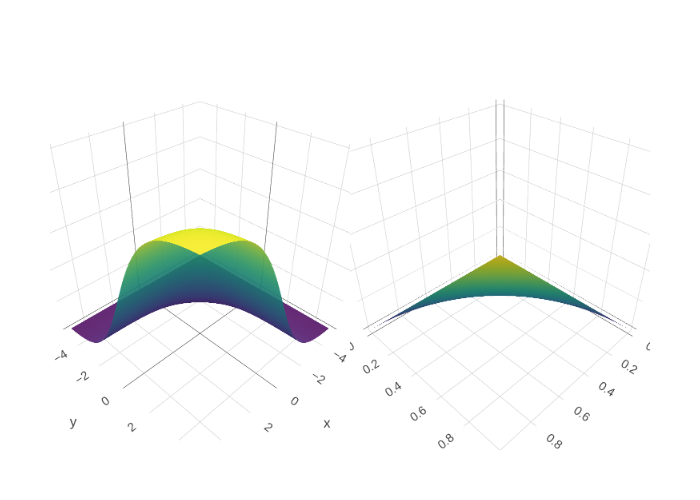

In [9]:
plog = plotly_distribution((x,y) -> 1/(1+exp(-x))*1/(1+exp(-y)), copula = false, resolution = 5)
pcop = plotly_distribution((x,y) -> x*y)

[plog pcop]

Because the copula shows that the relationship between $x$ and $y$ is totally independent (i.e. $\frac{\partial}{\partial x}(y) = 1$), any chosen value of $x$ will not impact the subsequent value of $y$ and the uniform values chosen will not be impacted by the inter-dependence. This is not always true and is why copulas are important, they provide a very raw description about the inter-dependence of multiple variables.

By generating uniform values 

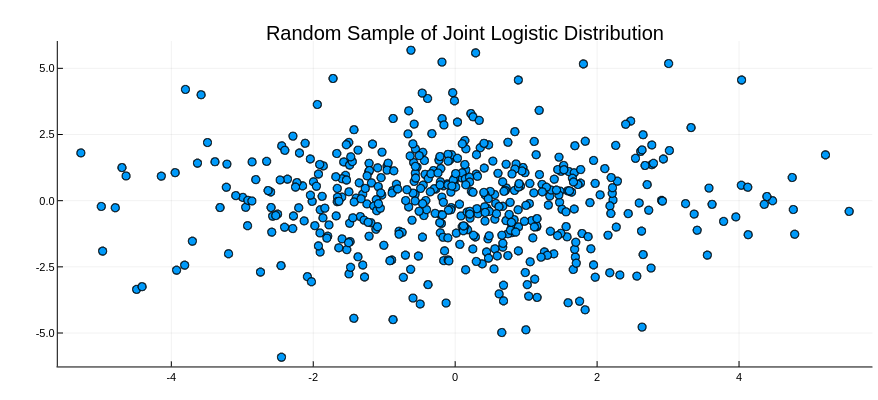

In [10]:
# Use the plotlyjs backend
plotlyjs()
n = Int(5*1E2)
#X vals
    ## Get some uniform values
    unif_vals = rand(Uniform(0,1), n)
    ## Feed them into the inverse    
    xvals = [inv_sig(x) for x in unif_vals]

# Yvals
    ## Get some uniform values
    unif_vals = rand(Uniform(0,1), n)
    ## Feed them into the inverse    
    yvals = [inv_sig(y) for y in unif_vals]

Plots.scatter(xvals, yvals,
              title = "Random Sample of Joint Logistic Distribution",
              label = false)


### Bivariate Distributions

In the preceeding example, the value of $x$ was entirely independent from the value of $y$, this means that it was possible to generate two sets of uniform random values without paying mind to the relationship between $x$ and $y$ (because there was no relationship, they were independent).



In many distributions variabels are inter-related, to make this point, consider an *Archimedean copulae* from the Ali-Mikhail-Haq <sup>[Ali-Mikhail]</sup> family:<sup>[SMHH, p. 398]</sup>

$$
\frac{uv}{1-\theta\left(1-u\right)\left(1-v\right)};\quad\forall\theta\in\left[-1,1\right]
$$

If we stick to using the logistic distribution ($\frac{1}{1+e^{-x}}$) to describe the marginals and set the following parameters: 



* $\theta = 1$
* $u = 0.7$
* $v = 0.5$

a corresponding joint distribution can be solved by using the definition of a copula:

$$\begin{aligned}
H\left(x,y\right)&=C\left(F\left(x\right),G\left(y\right)\right) \\
&=C\left(\frac{1}{1+e^{-x}}, \frac{1}{1+e^{-y}}  \right) \\
&= \frac{\frac{1}{1+e^{-x}} \frac{1}{1+e^{-y}}}{1-\left(1-\frac{1}{1+e^{-x}}\right)\left(1-\frac{1}{1+e^{-y}}\right)};\quad\forall\theta\in\left[-1,1\right] \\
&= \frac{e^{0.7 x+0.5 y}}{e^{0.7 x+0.5 y}+e^{0.7 x}+e^{0.5 y}}
\end{aligned}$$


This joint distribution function and copula can be visualised:

In [13]:
Joint_Log_Ali(x,y) = exp(0.7*x + 0.5* y)/(exp(0.7*x) + exp(0.7*x + 0.5*y) + exp(0.5*y))


Joint_Log_Ali (generic function with 1 method)

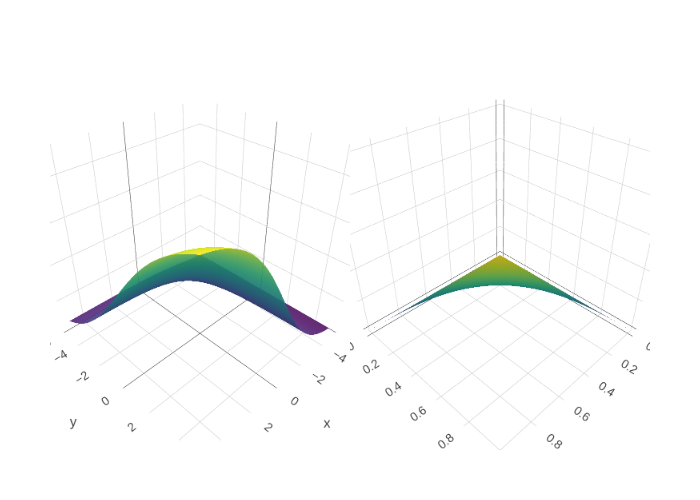

In [14]:
pAliLog = plotly_distribution(Joint_Log_Ali, copula = false, resolution = 5)
pAliCop = plotly_distribution((x,y) -> (x*y)/(1-(1-x)*(1-y)))

[pAliLog pAliCop]

The Conditional distribution function for $y$ can be shown to be a function $c_x(y)$ such that it is given by the partial derivative (see below), this can be understood intuitively because the partial derivative describes the rate of change between the two variables.
            
$$
c_x(y) = \frac{\partial}{\partial x} \left(C \left(x, y\right)\right)
$$

By inversing this function, it can be given uniform values and they will correspond to the uniform probability corresponding to the $x$ values.

To summmarise, to generate random values from a multi-variate distribution:

1. Generate uniform values $u,t \in \left[0,1\right]$
2. Inverse the marginal functions and put them back through the joint distribution function to find the copula
3. Find the partial derivative $\frac{\partial}{\partial x} \left(C \left(x, y\right)\right)$ and inverse it to get the inverse conditional distribution function
4. Feed the uniform values through the inverse function and then through the inverse conditional distribution function in order to get random values corresponding to the joint distribution.

The partial derivative can be solved Using the Sympy.jl package:

In [15]:
# Import the Package
using SymPy

@vars x
@vars u
@vars v

diff((u*v)/(1 - (1 - u)*(1 - v)), u) |> simplify


       2      
      v       
──────────────
             2
(u⋅v - u - v) 

The inverse of which is given by:

$$
\frac{u^2 v-u v-u \sqrt{v}}{u^2 v-2 u v+v-1}
$$

This can then be combined to generate the random values:

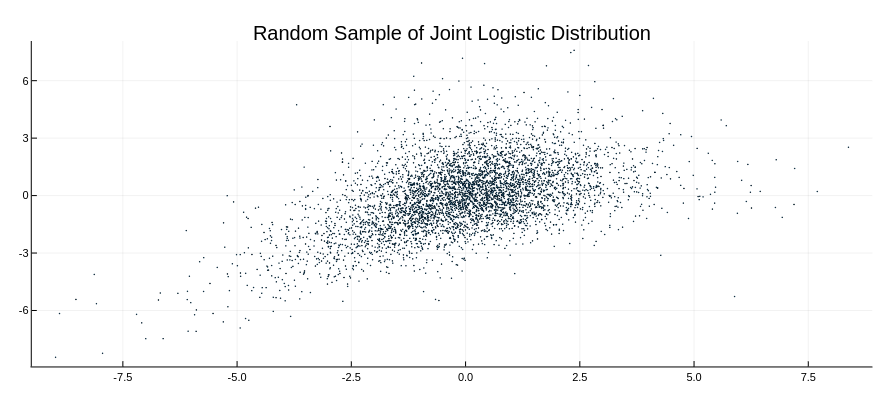

In [16]:
# Use the plotlyjs backend
plotlyjs()
n = Int(5*1E3)

# Generate uniform Data
u = rand(Uniform(0,1), n)
t = rand(Uniform(0,1), n)

# Use the inverse Conditional distribution function to get v
v = map((u, t) -> (-u*sqrt(t) - u*t + u^2*t)/(-1 + t - 2*u*t + u^2*t), u, t)


# (-u sqrt(t) - u t + u^2 t)/(-1 + t - 2 u t + u^2 t)

# Solve X and y using the Inverse Marginals
x = map(x -> inv_sig(x), u)
y = map(y -> inv_sig(y), v)


# Plot the Data

Plots.scatter(x,y,
              title = "Random Sample of Joint Logistic Distribution",
              label = false, markersize = 0.3)


#### Verifying Distribution with a Goodness of Fit Test

A Goodness of Fit test could be used to determine whether or not this distribution violates the given joint probability distribution, the Anderson-Darling, Chi-Squared and Kolmogorov-Smirnov tests would all be appropriate, the limited power of the Kolmogorov-Smirnov test is of no great concern in this case as the number of data points that can be generated is arbitrary.

This test has not yet been implemented to verify this distribution, below is a rough sketch of how it might be implemented:

In [17]:
using StatsBase

# Create a Histogram of Values
hx = fit(Histogram, x)   # See hx.edges and hx.weights
hy = fit(Histogram, y)


# Outer product with .* broadcast
# https://stackoverflow.com/a/44592419
  # obs = transpose(hy.weights).*hx.weights./sum(hx.weights) 
# This does not seem appropriate

vals = [ Joint_Log_Ali(x, y) for x in [1:10...]./10 for y in [1:10...]./10]
reshape(vals, 10, 10)


10×10 Matrix{Float64}:
 0.346786  0.354536  0.362081  0.369411  …  0.396442  0.402605  0.408528
 0.352456  0.360465  0.368267  0.375852     0.40387   0.410268  0.41642
 0.358025  0.366291  0.374351  0.382191     0.411198  0.417833  0.424215
 0.363488  0.372011  0.380327  0.388423     0.418421  0.425293  0.431906
 0.368841  0.377621  0.386192  0.394542     0.42553   0.43264   0.439486
 0.374082  0.383116  0.391941  0.400544  …  0.432521  0.439868  0.446947
 0.379207  0.388493  0.397571  0.406426     0.439387  0.446971  0.454283
 0.384214  0.393751  0.403079  0.412184     0.446124  0.453945  0.461488
 0.389102  0.398885  0.408461  0.417814     0.452727  0.460783  0.468557
 0.393868  0.403895  0.413716  0.423314     0.459192  0.467481  0.475485

#### Prove the Conditional Distribution Function


The conditional probability of two events $A$ and $B$ is given by:

\begin{align*}
    \mathrm{P}\left( A \mid B \right) = \frac{P\left( A \cup B \right) }{\mathrm{P}\left( A \right) }
.\end{align*}

This can be related to a continuous distribution:

\begin{align*}
    \mathrm{P}\left( V \leq v \mid U \leq u \right) = \frac{\mathrm{C}\left( u,v \right) }{F\left( u \right) }
.\end{align*}

Consider $u$  within some interval:

\begin{align*}
    \mathrm{P}\left( V \leq v \mid U \in \left[ u, u + u + \Delta u \right]  \right) &= \frac{\mathrm{P}\left( u \in \left[ u, u + \Delta u \right] \land  V \leq v \right) }{\mathrm{P}\left( u \in \left[ u, u + \Delta u \right]  \right) } \\
    &= \frac{C\left( u + \Delta u, v \right) - c\left( u,v \right) }{F\left( u+ \Delta u \right) - F\left( u \right) } \\
    P\left( V \leq v \mid U = u \right)  &= \lim_{\Delta u \rightarrow  0}\left( \mathrm{P}\left( V \leq v \mid u \in \left[ u, u + \Delta u \right]  \right)  \right) \\
    &= \lim_{\Delta u \rightarrow  0}\left( \frac{C\left( u + \Delta u, v \right) -C \left( u,v \right) }{F\left( U + \Delta u \right) - F \left( u \right) } \right) \\
\end{align*}

This limit is in the form of $\frac{0}{0}$ so *L'Hospital's Rule* can be applied, hence:

\begin{align*}
P\left( V \leq v \mid U = u \right)  &= \lim_{\Delta u \rightarrow  0}\left( \frac{ \frac{\partial }{\partial \Delta u}\left( C\left( u + \Delta u, v \right)  \right)  }{ \frac{\partial }{\partial \Delta u} \left( F\left( u+ \Delta u \right)  \right)   } \right) \\
&= \lim_{\Delta u \rightarrow  0}\left( \frac{\partial \left( C\left( u + \Delta u, v \right)  \right) }{\partial \left( F\left( u + \Delta u \right)  \right) } \right) \\
&= \frac{\partial \left( C\left( u,v \right)  \right) }{\partial \left( F\left( u \right)  \right) } \\
&= \frac{\partial C}{\partial u}
\end{align*} 
 


### MultiVariate Distributions

The Clayton copula can be extended into 3 variables <sup>[ORC]</sup>, by setting $\theta=1$ a copula of that family is given by:

$$
H(x,y,z) = \frac{1}{x+y+z-2}
$$

and by substituting in logistic marginals:

$$
H(\frac{1}{e^{-x}+1},\frac{1}{e^{-y}+1},\frac{1}{e^{-z}+1}) = \frac{1}{\frac{1}{e^{-x}+1}+\frac{1}{e^{-y}+1}+\frac{1}{e^{-z}+1}-2}
$$

The next step is to solve the Inverse Conditional Distribution Function. the value $w$ can be chosen uniformly, then the next value $v$ will depend on that value and finally the $U$ will depend on $v$ and $w$.
$$\begin{aligned}
P(U \leq u \mid V \leq v \mid W = w) &= \frac{\partial}{\partial w}\left(C\right) \\
&= -\frac{e^{-z}}{\left(e^{-z}+1\right)^2 \left(\frac{1}{e^{-x}+1}+\frac{1}{e^{-y}+1}+\frac{1}{e^{-z}+1}-2\right)^2}
\end{aligned}$$

$$\begin{aligned}
P(U \leq u \mid V=v \mid W = w) &= \frac{\partial}{\partial v}\left(\frac{\partial}{\partial w}\left(C\right)\right) \\
&= \frac{2 e^{-y-z}}{\left(e^{-y}+1\right)^2 \left(e^{-z}+1\right)^2 \left(\frac{1}{e^{-x}+1}+\frac{1}{e^{-y}+1}+\frac{1}{e^{-z}+1}-2\right)^3}
\end{aligned}$$

This can be verified in Julia like so:

In [18]:
# Import the Package
using SymPy

@vars u
@vars v
@vars w

diff(1/(1/(1+exp(-u))+1/(1+exp(-v))+1/(1+exp(-w))-2), w) |> simplify


             2         2        
     ⎛ u    ⎞  ⎛ v    ⎞   w     
    -⎝ℯ  + 1⎠ ⋅⎝ℯ  + 1⎠ ⋅ℯ      
────────────────────────────────
                               2
⎛ u    v    w    u + v + w    ⎞ 
⎝ℯ  + ℯ  + ℯ  - ℯ          + 2⎠ 

In [19]:
diff(
    diff(
        1/(1/(1+exp(-u))+1/(1+exp(-v))+1/(1+exp(-w))-2),
        w
    ),
v
) # |> simplify

                           -v  -w                        
                        2⋅ℯ  ⋅ℯ                          
─────────────────────────────────────────────────────────
         2          2                                   3
⎛     -v⎞  ⎛     -w⎞  ⎛        1         1         1   ⎞ 
⎝1 + ℯ  ⎠ ⋅⎝1 + ℯ  ⎠ ⋅⎜-2 + ─────── + ─────── + ───────⎟ 
                      ⎜          -w        -v        -u⎟ 
                      ⎝     1 + ℯ     1 + ℯ     1 + ℯ  ⎠ 

The inverse functions of these are however very complex, an initial and incomplelte attempt was made in Mathematica but this requires further investigation:

```mathematica
Clayton[x_, y_, z_] := (1/(x + y + z - 2))
H[x_, y_, z_] := Clayton[1/(1 + E^-x), 1/(1 + E^-y), 1/(1 + E^-z)]


(* Solve the first Inverse Conditional Probability *)
pdeOne[x_, y_, z_] := D[H[x, y, z], z] // Function[z, #] & // InverseFunction

(* Solve the Second Inverse Conditional Probability *)
pdeTwo[x_, y_, z_] := D[H[x, y, z], z] // D[#, y] & // Function[z, #] & // InverseFunction


(* Create a Function to return the values *)

Genvals[] := Module[{},
  u = RandomReal[{0, 1}];
  s = RandomReal[{0, 1}];
  t = RandomReal[{0, 1}];
  
  
  
  v = pdeOne[u, s, t ] // N;
  w = pdeTwo[u, v, t] // N;
  
  x = Log[-(u/(-1 + u))]/-0.5 // N;
  
  y = Log[-(v/(-1 + v))]/-0.5;
  z = Log[-(w/(-1 + w))]/-0.7;
  Return[{x, y, z}]
  ]




(* Create a 3d Plot *)

D[H[x, y, z], z] // D[#, y] & // Function[z, #] & // InverseFunction

```

#### Verifying Distribution with a Goodness of Fit Test

Not yet implemented

## Further Work

* The Multivariate Sampling needs to be reviewed
* A goodness of fit test needs to be implemented in order to identify mistakes
* More examples are needed
* Real world applications to Hydrology (flooding, droughts, rainfall), risk analysis and finance would be desirable.

## References


| Cite Key                       | Source                                                                                                   |
| ---                            | ---                                                                                                         |
| ***<a name="WIO442"> [WIO442]</a>*** | JuliaGizmos. (2021, June 07). WebIO.jl. </br>Retrieved from <https://github.com/JuliaGizmos/WebIO.jl/issues/442> |
| **[aur-ipympl]**               | AUR (en) - python-ipympl. (2021, April 06). </br>Retrieved from https://aur.archlinux.org/packages/python-ipympl |
| **[Dis.JL-416]** | How to use Pkg.dependencies() instead of Pkg.installed() - Usage - JuliaLang. (2021, March 11). </br>Retrieved from https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/15|
| **[Ali-Mikhail]** |Ali, M. M., Mikhail, N. N., & Haq, M. S. (1978). A class of bivariate distributions including the bivariate logistic. *J. Multivariate Anal.*, 8(3), 405–412. doi: 10.1016/0047-259X(78)90063-5 |
| **[SMHH]**| Rajib Maity. *Statistical Methods in Hydrology and Hydroclimatology*. New York, NY: Springer Berlin Heidelberg, 2018.
|
| **[NEL]** | Nelsen, Roger B. *An Introduction to Copulas*. 2. ed. 2006. Springer Series in Statistics. New York, NY </br> <https://www.springer.com/gp/book/9780387286594>|
| **[EoMLIP]** | Lipschitz condition - Encyclopedia of Mathematics. (2021, May 16). </br> Retrieved from https://encyclopediaofmath.org/wiki/Lipschitz_condition |
| **[INK]** | Inkscape Dev Team, (2021, June 07). *Inkscape*. </br> Retrieved from https://inkscape.org |
| **[LuH2O]** | Lu Chen, and Shenglian Guo. Copulas and Its Application in Hydrology and Water Resources. New York, NY: Springer Berlin Heidelberg, 2018. |
| **[MATHMOD]** | Frank Giordano, Steven Horton, William Fox. A First Course in Mathematical Modelling (version 5). 5th ed. Brooks/Cole, 2014. |
| **[PICTON]** | Picton, Philip. Neural Networks. Basingstoke, Hampshire ; New York: Palgrave, 1994.|
| **[ISL]** | James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, eds. An Introduction to Statistical Learning: With Applications in R. Springer Texts in Statistics 103. New York: Springer, 2013. |
| **[ORC]** | Orcel, Olivier, Philippe Sergent, and François Ropert. “Trivariate Copula to Design Coastal Structures.” Preprint. Sea, Ocean and Coastal Hazards, March 19, 2020. https://doi.org/10.5194/nhess-2020-80.|





<!--- 
I could hyperlink the citations like so:

```html
<a name="WIO442"> [WIO442]</a>
<a href="#WIO442"><sup>[WIO442]</sup></a>
```

however, the links don't work inside *Jupyter* and they only create more work so don't bother

--->


